In [46]:
import os
from dotenv import load_dotenv
from datetime import datetime

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

In [47]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [48]:

llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-22c77023-1c08-4b44-9b5b-bce3333a2dba-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [4]:
llm.invoke("hi").content

'Hi there! How can I help you today?'

In [49]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number


multiply({"first_number":24,"second_number":364})

8736

In [50]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result


search("who is a current president of USA?")

[{'url': 'https://www.usa.gov/presidents',
  'content': 'Presidents, vice presidents, and first ladies | USAGov An official website of the United States government A .gov website belongs to an official government organization in the United States. Learn about the duties of president, vice president, and first lady of the United States. President of the United States The president of the United States is the: Former U.S. presidents The United States has had 46 former U.S. presidents. Vice president of the United States The vice president of the United States presides over the U.S. Senate and takes over the role of president of the United States if the president is unable to perform their duties. The 50th and current vice president of the United States is James David (JD) Vance.'},
 {'url': 'https://www.whitehouse.gov/administration/',
  'content': 'The Trump Administration Search Search for:  Press Enter to Search Trump 45th & 47th President of the United States After a landslide electi

In [51]:
tools=[search,multiply]

model_with_tools = llm.bind_tools(tools)

tool_mapping={tool.name: tool for tool in tools}

tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x126936200>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x126935080>)}

In [8]:
response = model_with_tools.invoke("who is a current president of USA?")

response

AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "who is president of USA right now"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-9b1d1f57-e293-41d5-9e62-923c7004638d-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is president of USA right now'}, 'id': 'c5827ba5-24be-4a64-a0f1-11539dd5521d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 36, 'output_tokens': 9, 'total_tokens': 45, 'input_token_details': {'cache_read': 0}})

In [10]:
tool_details=response.tool_calls

tool_details

[{'name': 'search',
  'args': {'query': 'who is president of USA right now'},
  'id': 'c5827ba5-24be-4a64-a0f1-11539dd5521d',
  'type': 'tool_call'}]

In [11]:
tool_details[0]["name"]

'search'

In [22]:
tool_details[0]["args"]

{'query': 'who is president of USA right now'}

In [23]:
tool_mapping[tool_details[0]["name"]].invoke(tool_details[0]["args"])


[{'url': 'https://www.instagram.com/potus/?hl=en',
  'content': 'President Donald J. Trump 45th & 47th President of the United States. The Golden Age of America Begins Right Now.'},
 {'url': 'https://www.whitehouse.gov/',
  'content': 'The White House Administration The White House President Donald J. Trump Search Administration Search for:  Press Enter to Search America Is Back This will truly be the golden age of America. The Administration Trump President of the United States VICE PRESIDENT OF THE UNITED STATES Melania Trump First Lady OF THE UNITED STATES Of the 47th Administration President Trump is committed to lowering costs for all Americans, securing our borders, unleashing American energy dominance, restoring peace through strength, and making all Americans safe and secure once again. Get direct updates from The White House in your inbox. The White house THE WHITE HOUSE Administration The White House 1600 Pennsylvania Ave NW'},
 {'url': 'https://www.whitehouse.gov/administrat

In [61]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

def invoke_model(state:AgentState):
    print("inside model")
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

def invoke_tool(state:AgentState):
    print("inside tool")
    tool_details= state['messages'][-1].tool_calls[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("name")}')
    
    if tool_details.get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['name']].invoke(tool_details.get("args"))
    return {"messages" : [response]}



def router(state):
    tool_calls = state['messages'][-1].tool_calls
    if len(tool_calls):
        return "tool"
    else:
        return "end"
    


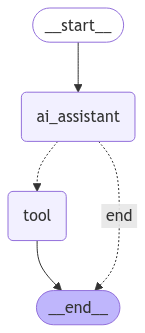

In [62]:
graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("ai_assistant", invoke_model)

graph.add_node("tool", invoke_tool)

graph.add_conditional_edges("ai_assistant", router, {"tool": "tool","end": END,})

graph.add_edge("tool", END)

#graph.add_edge("tool", "ai_assistant")

graph.set_entry_point("ai_assistant")


app = graph.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [63]:

for s in app.stream({"messages": ["who is upcoming president of USA?"]}):
    print(list(s.values())[0])
    print("----")

inside model
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "who is upcoming president of USA?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-82d96ce1-47a7-469d-b883-9cc4cb27c061-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is upcoming president of USA?'}, 'id': 'e80af920-917e-4060-b1f1-5a4fe89227b1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 35, 'output_tokens': 9, 'total_tokens': 44, 'input_token_details': {'cache_read': 0}})]}
----
inside tool
Selected tool: search
{'messages': [[{'url': 'https://www.britannica.com/event/United-States-presidential-election-of-2024', 'content': 'United States presidential election of 2024 | Background, Candidates, Donald Trump, Joe Biden, Indictments, & Facts | Britannica Ask the Chatbot Games & Quizzes History & Society Science & Tech Biographies Animals & Nature

In [64]:
for s in app.stream({"messages": ["what is multiplication of 23 and 46?"]}):
    print(list(s.values())[0])
    print("----")

inside model
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"second_number": 46.0, "first_number": 23.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-98026b55-a2c5-463a-882a-cb619cd060fa-0', tool_calls=[{'name': 'multiply', 'args': {'second_number': 46.0, 'first_number': 23.0}, 'id': '5c9bc4b7-56f0-4b6f-95c9-2db2910657f9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 40, 'output_tokens': 7, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}})]}
----
inside tool
Selected tool: multiply
{'messages': [1058]}
----


LangGraph supports human-in-the-loop workflows in a number of ways. In this section, we will use LangGraph's interrupt_before functionality to always break the tool node.

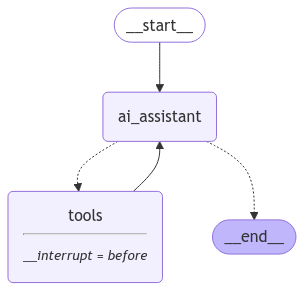

In [28]:

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

tavily=TavilySearchResults()


tools = [tavily]


llm_with_tools = llm.bind_tools(tools)

def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

memory = MemorySaver()

graph_builder = StateGraph(AgentState)
graph_builder.add_node("ai_assistant", ai_assistant)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)


graph_builder.add_edge(START, "ai_assistant")

graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "ai_assistant")


app2 = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [29]:
user_input = "what is current a capital of india?"
config = {"configurable": {"thread_id": "1"}}


# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is current a capital of india?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fe4f8986-c790-45bf-b58f-84ac83051300)
 Call ID: fe4f8986-c790-45bf-b58f-84ac83051300
  Args:
    query: current capital of India


In [ ]:
snapshot = app2.get_state(config)



In [31]:
snapshot.next

('tools',)

In [33]:

last_message=snapshot.values["messages"][-1]

last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current capital of India'},
  'id': 'fe4f8986-c790-45bf-b58f-84ac83051300',
  'type': 'tool_call'}]

In [35]:

# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")


for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fe4f8986-c790-45bf-b58f-84ac83051300)
 Call ID: fe4f8986-c790-45bf-b58f-84ac83051300
  Args:
    query: current capital of India
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://currentaffairs.adda247.com/states-and-capitals/", "content": "States and Capitals of India 2025: Updated List of All 28 States & 8 Union Territories It is divided into 28 states and 8 union territories, each with its own capital city. The states and capitals of India form a vibrant tapestry, reflecting the nation’s diversity in culture, traditions, and innovation. States and Capitals of India 2025 Total states in India of 28 states and 8 union territories. State and Capital of India-UT’s The capital of India is New Delhi, which is a union territory. The states and union territories of India are home to a div

In [36]:

user_input = "what is a weather there?"

config = {"configurable": {"thread_id": "1"}}

# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)


for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

        

================================ Human Message =================================

what is a weather there?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (c4b3511c-69a1-4f9e-b434-37209fd516c8)
 Call ID: c4b3511c-69a1-4f9e-b434-37209fd516c8
  Args:
    query: weather in New Delhi


In [37]:

snapshot = app2.get_state(config)
snapshot.next

('tools',)

In [38]:

last_message=snapshot.values["messages"][-1]
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in New Delhi'},
  'id': 'c4b3511c-69a1-4f9e-b434-37209fd516c8',
  'type': 'tool_call'}]

In [39]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")


for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (c4b3511c-69a1-4f9e-b434-37209fd516c8)
 Call ID: c4b3511c-69a1-4f9e-b434-37209fd516c8
  Args:
    query: weather in New Delhi
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'New Delhi', 'region': 'Delhi', 'country': 'India', 'lat': 28.6, 'lon': 77.2, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1740704569, 'localtime': '2025-02-28 06:32'}, 'current': {'last_updated_epoch': 1740704400, 'last_updated': '2025-02-28 06:30', 'temp_c': 20.4, 'temp_f': 68.7, 'is_day': 0, 'condition': {'text': 'Patchy rain nearby', 'icon': '//cdn.weatherapi.com/weather/64x64/night/176.png', 'code': 1063}, 'wind_mph': 6.0, 'wind_kph': 9.7, 'wind_degree': 158, 'wind_dir': 'SSE', 'pressure_mb': 1013.0, 'pressure_in': 29.91, 'precip_mm': 0.02, 'precip_in':

In [40]:

app2.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='what is current a capital of india?', additional_kwargs={}, response_metadata={}, id='0780b5c1-0f9a-4e5b-8119-f4fedd2487ce'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "current capital of India"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8f69d2c1-069b-4340-937a-107c7beb48a6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current capital of India'}, 'id': 'fe4f8986-c790-45bf-b58f-84ac83051300', 'type': 'tool_call'}], usage_metadata={'input_tokens': 55, 'output_tokens': 13, 'total_tokens': 68, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='[{"url": "https://currentaffairs.adda247.com/states-and-capitals/", "content": "States and Capitals of India 2025: Updated List of All 28 States & 8 Union Territories It is divi

In [41]:
snapshot=app2.get_state(config)
snapshot.next

user_input = "give me the recent news of it?"

config = {"configurable": {"thread_id": "1"}}


# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the recent news of it?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (6fdb6972-fbe5-44a5-9e22-e78bb009193d)
 Call ID: 6fdb6972-fbe5-44a5-9e22-e78bb009193d
  Args:
    query: recent news of New Delhi


In [42]:
snapshot=app2.get_state(config)

current_message = snapshot.values["messages"][-1]

current_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (6fdb6972-fbe5-44a5-9e22-e78bb009193d)
 Call ID: 6fdb6972-fbe5-44a5-9e22-e78bb009193d
  Args:
    query: recent news of New Delhi


In [43]:
tool_call_id = current_message.tool_calls[0]["id"] 

tool_call_id
     

'6fdb6972-fbe5-44a5-9e22-e78bb009193d'

In [44]:
from langchain_core.messages import AIMessage, ToolMessage


answer = "it is just related to raining which is happing on daily basis"


new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]


app2.update_state(
    config,
    {"messages": new_messages},
)
     

     

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff5706-ced9-689c-800c-ec44b124a2b3'}}

In [45]:

print(app2.get_state(config).values["messages"][-1:])

[AIMessage(content='it is just related to raining which is happing on daily basis', additional_kwargs={}, response_metadata={}, id='03e8b8e2-5f91-4ca9-b843-261675d2ae32')]
